In [1]:
import cv2
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch, torch.nn as nn, torch.nn.functional as F, math, numpy as np
import glob, os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [2]:
class ImageDataset(Dataset):
    def __init__(self, carpeta, size=224):
        self.paths = sorted(glob.glob(os.path.join(carpeta, "*.png")))
        self.size = size

    def letterbox(self, img):
        h, w = img.shape[:2]
        s = self.size / max(h, w)
        nh, nw = int(h * s), int(w * s)
        img_resized = cv2.resize(img, (nw, nh), interpolation=cv2.INTER_AREA)
        pad_top = (self.size - nh) // 2
        pad_left = (self.size - nw) // 2
        out = np.full((self.size, self.size, 3), 114, dtype=np.uint8)
        out[pad_top:pad_top + nh, pad_left:pad_left + nw] = img_resized
        return out

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.paths[idx], cv2.IMREAD_COLOR)
        img = self.letterbox(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.0
        img = torch.tensor(img).permute(2, 0, 1)  # C,H,W
        return img

dataset = ImageDataset("objetos_salon/processed/cpu", size=224)#ajustar tamaño despues
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [3]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    total_loss = 0
    for imgs in loader:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, imgs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
    print(f"Época {epoch+1}, pérdida promedio: {total_loss/len(dataset):.5f}")

Época 1, pérdida promedio: 0.04607
Época 2, pérdida promedio: 0.04177
Época 3, pérdida promedio: 0.02665
Época 4, pérdida promedio: 0.01553
Época 5, pérdida promedio: 0.01196
Época 6, pérdida promedio: 0.00982
Época 7, pérdida promedio: 0.00884
Época 8, pérdida promedio: 0.00798
Época 9, pérdida promedio: 0.00738
Época 10, pérdida promedio: 0.00682


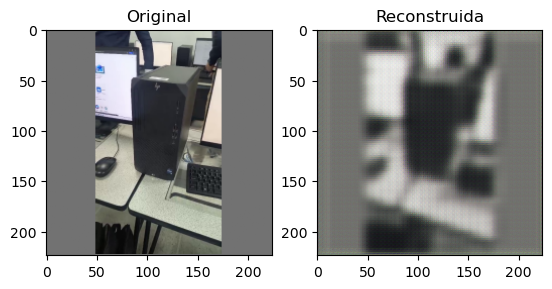

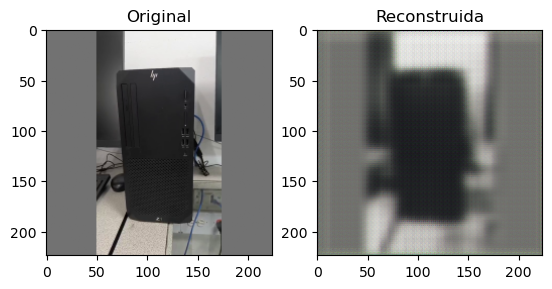

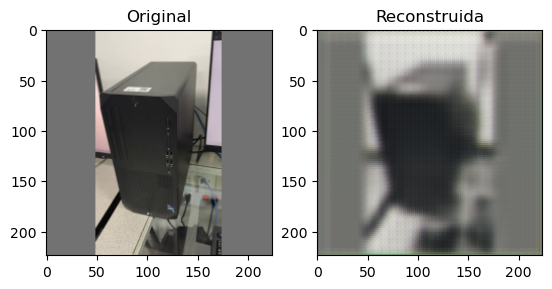

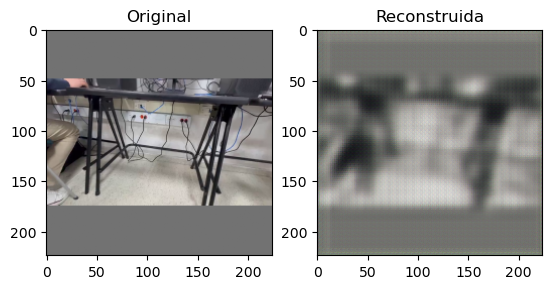

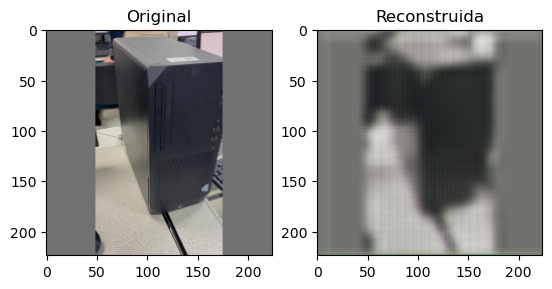

In [5]:
model.eval()
imgs = next(iter(loader))
imgs = imgs[:5].to(device)
recon = model(imgs).detach().cpu()

for i in range(5):
    orig = imgs[i].cpu().permute(1,2,0).numpy()
    rec  = recon[i].permute(1,2,0).numpy()
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(orig); ax[0].set_title("Original")
    ax[1].imshow(rec); ax[1].set_title("Reconstruida")
    plt.show()

In [6]:
#espacio latente 

In [7]:
# Supone que model = Autoencoder() ya está entrenado
model.eval()

# Toma un lote de imágenes
imgs = next(iter(loader))
imgs = imgs.to(device)

# Paso solo por el encoder
with torch.no_grad():
    z = model.encoder(imgs)

print("Forma de z:", z.shape)
#32 imágenes (batch).
#128 mapas de activación de tamaño 16×16 cada uno.

Forma de z: torch.Size([32, 128, 28, 28])


In [8]:
z_flat = z.view(z.size(0), -1).cpu().numpy()
print("Forma vectorizada:", z_flat.shape)

Forma vectorizada: (32, 100352)


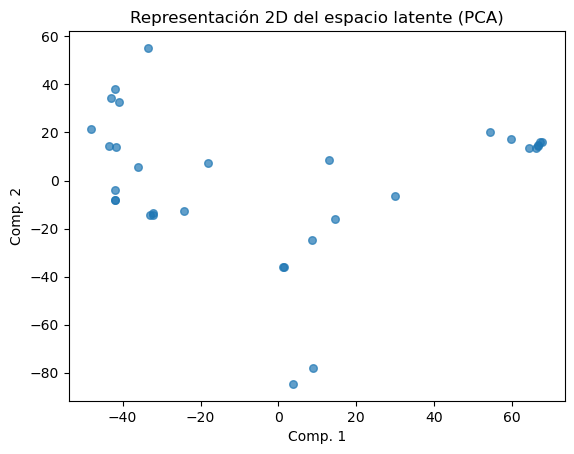

In [9]:
# reducción de dimensionalidad
z_pca = PCA(n_components=2).fit_transform(z_flat)
# o: z_tsne = TSNE(n_components=2, perplexity=30).fit_transform(z_flat)

plt.scatter(z_pca[:,0], z_pca[:,1], s=30, alpha=0.7)
plt.title("Representación 2D del espacio latente (PCA)")
plt.xlabel("Comp. 1")
plt.ylabel("Comp. 2")
plt.show()

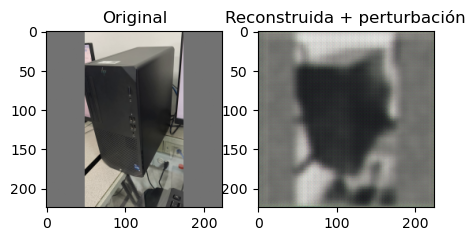

In [10]:
# Tomamos una imagen y su z
x = imgs[0:1]
with torch.no_grad():
    z = model.encoder(x)

# Pequeña perturbación del vector latente
delta = torch.randn_like(z) * 0.1
x_mod = model.decoder(z + delta)

# Mostrar original, reconstruida y perturbada
def show_pair(a, b, title_a, title_b):
    fig, ax = plt.subplots(1,2, figsize=(5,3))
    ax[0].imshow(a); ax[0].set_title(title_a)
    ax[1].imshow(b); ax[1].set_title(title_b)
    plt.show()

a = x[0].detach().cpu().permute(1,2,0).numpy()
b = x_mod[0].detach().cpu().permute(1,2,0).numpy()
show_pair(a, b, "Original", "Reconstruida + perturbación")

In [11]:
# super clasificador 

In [12]:
class LabeledImageDataset(Dataset):
    def __init__(self, root, size=224):
        self.size = size
        self.samples = []
        self.classes = sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root,d))])
        self.class_to_idx = {c:i for i,c in enumerate(self.classes)}
        for c in self.classes:
            for p in glob.glob(os.path.join(root, c, "*.png")):
                self.samples.append((p, self.class_to_idx[c]))

    def letterbox(self, img):
        h, w = img.shape[:2]
        s = self.size / max(h, w)
        nh, nw = int(h*s), int(w*s)
        r = cv2.resize(img, (nw, nh), interpolation=cv2.INTER_AREA)
        out = np.full((self.size, self.size, 3), 114, dtype=np.uint8)
        y0 = (self.size - nh)//2; x0 = (self.size - nw)//2
        out[y0:y0+nh, x0:x0+nw] = r
        return out

    def __len__(self): return len(self.samples)

    def __getitem__(self, i):
        p, y = self.samples[i]
        img = cv2.imread(p, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(self.letterbox(img), cv2.COLOR_BGR2RGB)
        x = torch.tensor(img, dtype=torch.float32).permute(2,0,1)/255.0
        return x, torch.tensor(y, dtype=torch.long)

In [13]:
ds = LabeledImageDataset("objetos_salon/processed", size=224)
n_classes = len(ds.classes)
loader = DataLoader(ds, batch_size=64, shuffle=True, num_workers=2)

encoder = model.encoder.eval()            # usa tu autoencoder entrenado
for p in encoder.parameters(): p.requires_grad = False
device = "cuda" if torch.cuda.is_available() else "cpu"
encoder.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
)

In [14]:
# modo A

In [15]:
# Extraer features (flatten de z)
X, Y = [], []
with torch.no_grad():
    for x, y in loader:
        z = encoder(x.to(device))                 # [B, C, H, W]
        z = torch.nn.functional.adaptive_avg_pool2d(z, 1)  # GAP -> [B,C,1,1]
        z = z.view(z.size(0), -1).cpu().numpy()   # [B, C]
        X.append(z); Y.append(y.numpy())
X = np.concatenate(X, axis=0); Y = np.concatenate(Y, axis=0)

Xtr, Xte, Ytr, Yte = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)
clf = LogisticRegression(max_iter=2000).fit(Xtr, Ytr)
pred = clf.predict(Xte)
print("Acc:", accuracy_score(Yte, pred))
print(classification_report(Yte, pred, target_names=ds.classes))

Acc: 0.4692982456140351
              precision    recall  f1-score   support

         cpu       0.00      0.00      0.00        31
        mesa       0.38      0.50      0.43        38
       mouse       0.45      0.74      0.56        34
        nada       0.83      0.50      0.62        20
    pantalla       0.55      0.52      0.53        33
       silla       0.41      0.68      0.51        38
     teclado       0.62      0.29      0.40        34

    accuracy                           0.47       228
   macro avg       0.46      0.46      0.44       228
weighted avg       0.44      0.47      0.43       228



/home/cristian/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cristian/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cristian/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape

In [16]:
# modo B

In [17]:

head = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),             # -> [B,C,1,1]
    nn.Flatten(),                        # -> [B,C]
    nn.Linear(128, n_classes)            # ajusta "128" a canales de tu encoder
).to(device)

crit = nn.CrossEntropyLoss()
opt = optim.Adam(head.parameters(), lr=1e-3)

for epoch in range(20):
    head.train(); tot=0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        with torch.no_grad():
            z = encoder(x)
        logits = head(z)
        loss = crit(logits, y)
        opt.zero_grad(); loss.backward(); opt.step()
        tot += loss.item()*x.size(0)
    print(f"epoch {epoch+1} loss {tot/len(ds):.4f}")

epoch 1 loss 1.9509
epoch 2 loss 1.9327
epoch 3 loss 1.9247
epoch 4 loss 1.9240
epoch 5 loss 1.9180
epoch 6 loss 1.9139
epoch 7 loss 1.9093
epoch 8 loss 1.9051
epoch 9 loss 1.9020
epoch 10 loss 1.8992
epoch 11 loss 1.8939
epoch 12 loss 1.8938
epoch 13 loss 1.8878
epoch 14 loss 1.8856
epoch 15 loss 1.8829
epoch 16 loss 1.8832
epoch 17 loss 1.8791
epoch 18 loss 1.8751
epoch 19 loss 1.8736
epoch 20 loss 1.8686


In [18]:
# modo C

In [19]:
for name, p in encoder.named_parameters():
    p.requires_grad = name.startswith("2.")  # ejemplo: sólo último bloque
opt = optim.Adam(list(filter(lambda t: t.requires_grad, encoder.parameters())) + list(head.parameters()), lr=1e-4)

In [20]:
for epoch in range(20):
    head.train(); tot=0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        with torch.no_grad():
            z = encoder(x)
        logits = head(z)
        loss = crit(logits, y)
        opt.zero_grad(); loss.backward(); opt.step()
        tot += loss.item()*x.size(0)
    print(f"epoch {epoch+1} loss {tot/len(ds):.4f}")

epoch 1 loss 1.8668
epoch 2 loss 1.8658
epoch 3 loss 1.8655
epoch 4 loss 1.8651
epoch 5 loss 1.8649
epoch 6 loss 1.8646
epoch 7 loss 1.8644
epoch 8 loss 1.8639
epoch 9 loss 1.8639
epoch 10 loss 1.8635
epoch 11 loss 1.8634
epoch 12 loss 1.8633
epoch 13 loss 1.8629
epoch 14 loss 1.8626
epoch 15 loss 1.8625
epoch 16 loss 1.8622
epoch 17 loss 1.8618
epoch 18 loss 1.8616
epoch 19 loss 1.8615
epoch 20 loss 1.8613


In [21]:
# experimento con diferentes tamaños de cuello

In [22]:
class AutoencoderK(nn.Module):
    def __init__(self, k=64):
        super().__init__()
        self.enc_base = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1), nn.ReLU(),
            nn.Conv2d(32,64, 3, 2, 1), nn.ReLU(),
            nn.Conv2d(64,128,3, 2, 1), nn.ReLU(),   # -> [B,128,16,16] para 224x224
        )
        self.enc_neck = nn.Conv2d(128, k, kernel_size=1)       # -> [B,k,16,16]
        self.dec_neck = nn.Conv2d(k, 128, kernel_size=1)       # <- [B,128,16,16]
        self.dec_base = nn.Sequential(
            nn.ConvTranspose2d(128,64,4,2,1), nn.ReLU(),
            nn.ConvTranspose2d(64,32,4,2,1),  nn.ReLU(),
            nn.ConvTranspose2d(32,3, 4,2,1),  nn.Sigmoid()
        )

    def encode(self, x):
        h = self.enc_base(x)
        return self.enc_neck(h)               # z: [B,k,16,16]

    def decode(self, z):
        h = self.dec_neck(z)
        return self.dec_base(h)

    def forward(self, x):
        z = self.encode(x)
        xhat = self.decode(z)
        return xhat, z

In [23]:
def train_ae(model, loader, device, epochs=10, lr=1e-3):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    for ep in range(epochs):
        model.train(); tot = 0
        for batch in loader:
            x = batch if isinstance(batch, torch.Tensor) else batch[0]
            x = x.to(device)
            opt.zero_grad()
            xhat, _ = model(x)
            loss = F.mse_loss(xhat, x)
            loss.backward(); opt.step()
            tot += loss.item() * x.size(0)
        print(f"época {ep+1:02d}  MSE {tot/len(loader.dataset):.6f}")

In [24]:
def eval_recon(model, loader, device, batches=5):
    model.eval(); mse_sum=0; n=0
    with torch.no_grad():
        for i, batch in enumerate(loader):
            x = batch if isinstance(batch, torch.Tensor) else batch[0]
            x = x.to(device)
            xhat, _ = model(x)
            mse = F.mse_loss(xhat, x).item()
            mse_sum += mse; n += 1
            if i+1 >= batches: break
    mse = mse_sum/n
    psnr = 10*math.log10(1.0/mse)
    return mse, psnr

In [25]:
def linear_probe(model, loader, device, class_names):
    X, Y = [], []
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            _, z = model(x)                                  # [B,k,16,16]
            z = F.adaptive_avg_pool2d(z, 1).view(z.size(0), -1).cpu().numpy()
            X.append(z); Y.append(y.numpy())
    X = np.concatenate(X); Y = np.concatenate(Y)
    Xtr, Xte, Ytr, Yte = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)
    clf = LogisticRegression(max_iter=2000).fit(Xtr, Ytr)
    acc = accuracy_score(Yte, clf.predict(Xte))
    return acc

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
k = 64
model = AutoencoderK(k=k)

# Entrenamiento (10 épocas sugeridas)
train_ae(model, loader, device, epochs=10, lr=1e-3)

# Reconstrucción: MSE y PSNR
mse, psnr = eval_recon(model, loader, device, batches=8)
print(f"MSE recon: {mse:.6f}   PSNR: {psnr:.2f} dB")

época 01  MSE 0.031495
época 02  MSE 0.013160
época 03  MSE 0.007635
época 04  MSE 0.006210
época 05  MSE 0.005565
época 06  MSE 0.005141
época 07  MSE 0.004552
época 08  MSE 0.003983
época 09  MSE 0.003664
época 10  MSE 0.003397
MSE recon: 0.003252   PSNR: 24.88 dB


In [27]:
acc = linear_probe(model, loader, device, class_names=getattr(ds, "classes", None))
print(f"Linear probe (k=64) accuracy: {acc:.4f}")

Linear probe (k=64) accuracy: 0.3246


In [28]:
# k = 128 a ver como nos va 